In [49]:

import tensorflow as tf
from tensorflow.keras import datasets, layers, models

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

Physical devices cannot be modified after being initialized


In [52]:
!conda list

# packages in environment at /home/team1/anaconda3/envs/tmp:
#
# Name                    Version                   Build  Channel
_libgcc_mutex             0.1                        main  
_openmp_mutex             4.5                       1_gnu  
_tflow_select             2.1.0                       gpu    anaconda
absl-py                   0.15.0             pyhd3eb1b0_0  
argon2-cffi               21.3.0             pyhd3eb1b0_0  
argon2-cffi-bindings      21.2.0           py39h7f8727e_0  
asttokens                 2.0.5              pyhd3eb1b0_0  
astunparse                1.6.3                      py_0    anaconda
attrs                     21.4.0             pyhd3eb1b0_0  
backcall                  0.2.0              pyhd3eb1b0_0  
blas                      1.0                    openblas    anaconda
bleach                    4.1.0              pyhd3eb1b0_0  
blinker                   1.4              py39h06a4308_0  
brotli                    1.0.9                he6710b0_2  


In [4]:
import os
import zipfile

In [5]:
os.listdir('./base_act')

FileNotFoundError: [Errno 2] No such file or directory: './base_act'

In [3]:
# 기본 경로
base_dir = './base_act'
train_dir = base_dir + '/train_set'
test_dir = base_dir + '/test_set'

In [4]:
import matplotlib.pylab as plt
import tensorflow_hub as hub
import tensorflow.compat.v1 as tf
from tensorflow.keras import layers

2022-03-21 05:27:02.059607: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [5]:
classifier_url ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2" 

In [6]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_url, input_shape=IMAGE_SHAPE+(3,))
])

2022-03-17 08:12:02.356369: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-03-17 08:12:02.357531: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-03-17 08:12:02.384754: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-17 08:12:02.386053: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:03:00.0 name: Tesla V100S-PCIE-32GB computeCapability: 7.0
coreClock: 1.597GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 1.03TiB/s
2022-03-17 08:12:02.386077: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-03-17 08:12:02.387926: I tensorflow/stream_executor/platform/defau

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [7]:
classifier.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              3540265   
Total params: 3,540,265
Trainable params: 0
Non-trainable params: 3,540,265
_________________________________________________________________


In [5]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
train_data = image_generator.flow_from_directory(train_dir,batch_size=32, target_size=(224, 224))
test_data = image_generator.flow_from_directory(test_dir,batch_size=32, target_size=(224, 224))

Found 5979 images belonging to 6 classes.
Found 240 images belonging to 6 classes.


In [6]:
for train_batch, label_batch in train_data:
  print("Image batch shape: ", train_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break


Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 6)


In [15]:
feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

In [16]:
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(224,224,3))

In [17]:
feature_batch = feature_extractor_layer(train_batch)
print(feature_batch.shape)

(32, 1280)


In [18]:
feature_extractor_layer.trainable = False

In [19]:
with tf.device("/gpu:0"):
    model = tf.keras.Sequential([
      feature_extractor_layer,
      layers.Dense(train_data.num_classes, activation='softmax')
    ])

In [20]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 7686      
Total params: 2,265,670
Trainable params: 7,686
Non-trainable params: 2,257,984
_________________________________________________________________


In [21]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss='categorical_crossentropy',
  metrics=['acc'])

In [22]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

2022-03-21 05:28:26.847496: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-21 05:28:26.847840: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:03:00.0 name: Tesla V100S-PCIE-32GB computeCapability: 7.0
coreClock: 1.597GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 1.03TiB/s
2022-03-21 05:28:26.847889: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-03-21 05:28:26.847912: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-03-21 05:28:26.847921: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2022-03-21 05:28:26.847930: I tensorflow/stream_executor/p

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 3860881646185203765,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 31589217152
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 5570848589915303399
 physical_device_desc: "device: 0, name: Tesla V100S-PCIE-32GB, pci bus id: 0000:03:00.0, compute capability: 7.0"]

22-03-21 05:28:26.848545: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1261] Device interconnect StreamExecutor with strength 1 edge matrix:
2022-03-21 05:28:26.848549: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1267]      0 
2022-03-21 05:28:26.848553: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1280] 0:   N 
2022-03-21 05:28:26.848616: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-21 05:28:26.848872: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-21 05:28:26.849135: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1406] Created TensorFlow device (/device:GPU:0 with 30125 MB memory) -> physical GPU (device: 0, name: Tesla V100S-PCIE-32GB, pci bus id: 0000:03:00

In [2]:
import time, random, datetime
import numpy as np
import tensorflow as tf
class DataLoader(tf.keras.utils.Sequence):
    def __len__(self):
        return 10
    def __getitem__(self, i):
        time.sleep(random.randint(1,2))
        #you could add a print here to see that it's out of order
        return i

2022-03-23 17:04:39.666858: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [45]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()
batch_stats_callback = CollectBatchStats()

In [46]:
np.ceil(train_data.samples/train_data.batch_size)

187.0

In [24]:
steps_per_epoch = np.ceil(train_data.samples/train_data.batch_size)
steps_test_per_epoch = np.ceil(test_data.samples/test_data.batch_size)


In [25]:
history = model.fit(train_data,
                    validation_data=test_data,
                    steps_per_epoch=steps_per_epoch,
                    epochs=15,
                    validation_steps=steps_test_per_epoch,
                    verbose=2)


Epoch 1/10
187/187 - 782s - loss: 1.2311 - acc: 0.5697 - val_loss: 0.9081 - val_acc: 0.7250
Epoch 2/10
187/187 - 777s - loss: 0.6431 - acc: 0.8339 - val_loss: 0.6317 - val_acc: 0.8292
Epoch 3/10
187/187 - 768s - loss: 0.4597 - acc: 0.8903 - val_loss: 0.5017 - val_acc: 0.8500
Epoch 4/10
187/187 - 779s - loss: 0.3519 - acc: 0.9236 - val_loss: 0.4270 - val_acc: 0.8875
Epoch 5/10
187/187 - 773s - loss: 0.2847 - acc: 0.9438 - val_loss: 0.3311 - val_acc: 0.9125
Epoch 6/10
187/187 - 774s - loss: 0.2370 - acc: 0.9574 - val_loss: 0.3040 - val_acc: 0.9125
Epoch 7/10
187/187 - 772s - loss: 0.2024 - acc: 0.9660 - val_loss: 0.2654 - val_acc: 0.9375
Epoch 8/10
187/187 - 772s - loss: 0.1756 - acc: 0.9731 - val_loss: 0.2250 - val_acc: 0.9417
Epoch 9/10
187/187 - 781s - loss: 0.1523 - acc: 0.9759 - val_loss: 0.2064 - val_acc: 0.9583
Epoch 10/10
187/187 - 774s - loss: 0.1374 - acc: 0.9816 - val_loss: 0.1988 - val_acc: 0.9542


In [26]:
import time
t = time.time()

export_path = "MobileNet V2_v4"
model.save(export_path, save_format='tf')

export_path

2022-03-21 08:00:04.854813: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: MobileNet V2_v4/assets


INFO:tensorflow:Assets written to: MobileNet V2_v4/assets


'MobileNet V2_v4'

In [3]:
reloaded = tf.keras.models.load_model('./black-belt/AImodel/base_TL_V4/MobileNet V2_v4')

OSError: SavedModel file does not exist at: ./black-belt/AImodel/base_TL_V4/MobileNet V2_v4/{saved_model.pbtxt|saved_model.pb}

In [97]:
result_batch = model.predict(test_batch)
reloaded_result_batch = reloaded.predict(test_batch)

In [98]:
reloaded.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_3 (KerasLayer)   (None, 1280)              1280      
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 7686      
Total params: 8,966
Trainable params: 7,686
Non-trainable params: 1,280
_________________________________________________________________


TypeError: float() argument must be a string or a number, not 'History'

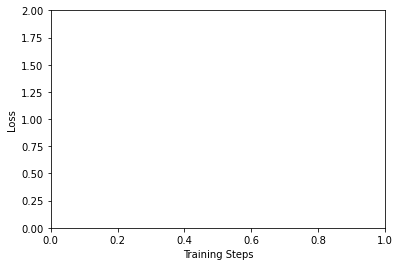

In [81]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

In [ ]:
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)

In [99]:
class_names = sorted(test_data.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
class_names

array(['Bodyhit_Left', 'Bodyhit_Right', 'Midblock_Left', 'Midblock_Right',
       'Topblock_Left', 'Topblock_Right'], dtype='<U14')

In [100]:
predicted_batch = model.predict(test_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

In [101]:
label_id = np.argmax(label_batch, axis=-1)

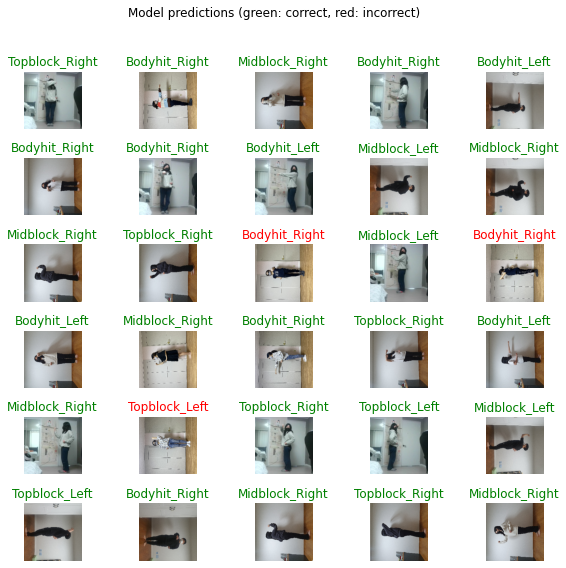

In [103]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(test_batch[n])
  color = "green" if predicted_id[n] == label_id[n] else "red"
  plt.title(predicted_label_batch[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")